<a href="https://colab.research.google.com/github/caio-olubini/Statistics-Projects/blob/main/Time_Series_Box_Jenkins_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt

# Loading dataset

In [ ]:
data = sm.datasets.get_rdataset('AirPassengers', 'datasets')
df = data.data

df.head(10)

,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121
5,1949.416667,135
6,1949.500000,148
7,1949.583333,148
8,1949.666667,136
9,1949.750000,119


# Data Preprocessing

In [ ]:
df.rename(columns={'value': '#Passengers'}, inplace=True)

Renaming column from value to #Passangers for clarity

In [ ]:
df['year'] = df['time'].astype(int)
df['month'] = (df['time'] - df['year']) * 12
df['month'] = df['month'].round().astype(int) + 1
df['month_year'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))
df.head()

,time,#Passengers,year,month,month_year
0,1949.000000,112,1949,1,1949-01-01
1,1949.083333,118,1949,2,1949-02-01
2,1949.166667,132,1949,3,1949-03-01
3,1949.250000,129,1949,4,1949-04-01
4,1949.333333,121,1949,5,1949-05-01


Converting time to month-year format.

# Data exploration

The **AirPassengers dataset** contains monthly totals of international airline passengers from 1949 to 1960. It's a classic example of time series data exhibiting trend and seasonality.

Format of Each Row: Each row in the dataset represents a single month's data.

- **time:** This column represents the time point (in years). Since it's monthly data, the values increment in fractions of a year (e.g., 1949.0, 1949.0833...).
- **value:** This column contains the number of international airline passengers for that specific month.

In [ ]:
df.describe()

,time,#Passengers,year,month,month_year
count,144.000000,144.000000,144.000000,144.000000,144
mean,1954.958333,280.298611,1954.500000,6.500000,1954-12-16 05:00:00
min,1949.000000,104.000000,1949.000000,1.000000,1949-01-01 00:00:00
25%,1951.979167,180.000000,1951.750000,3.750000,1951-12-24 06:00:00
50%,1954.958333,265.500000,1954.500000,6.500000,1954-12-16 12:00:00
75%,1957.937500,360.500000,1957.250000,9.250000,1957-12-08 18:00:00
max,1960.916667,622.000000,1960.000000,12.000000,1960-12-01 00:00:00
std,3.476109,119.966317,3.464102,3.464102,NaN


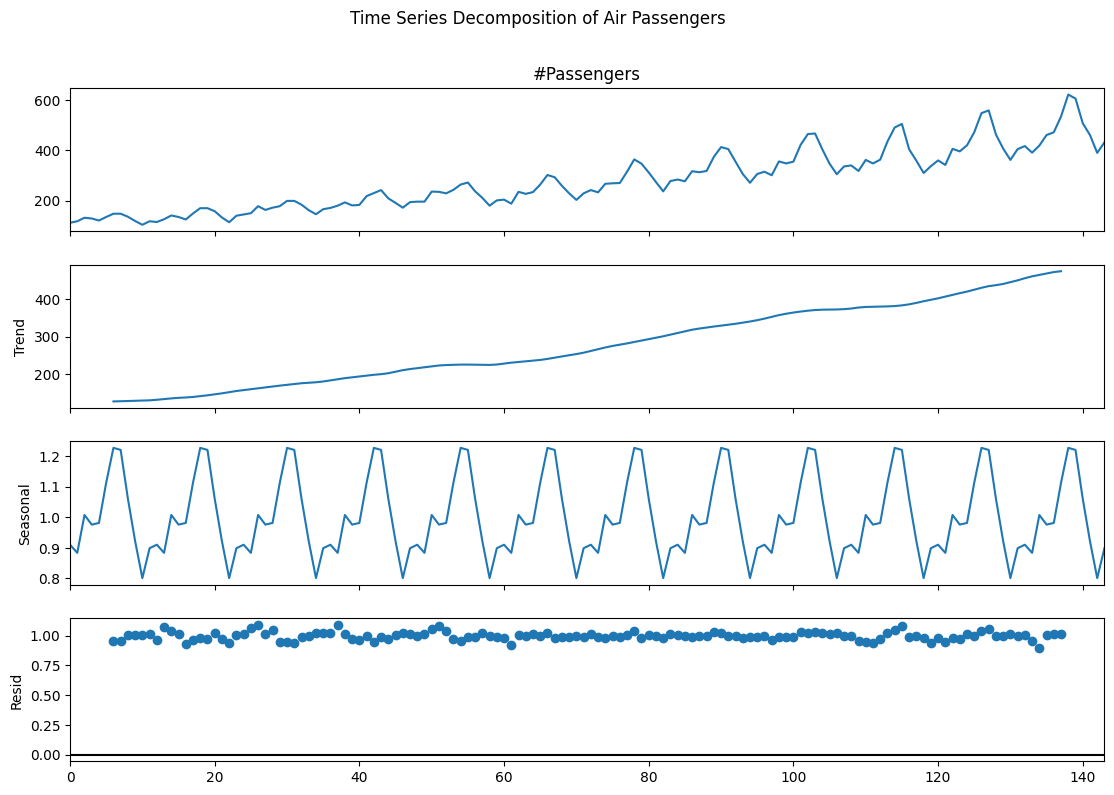

In [ ]:
decomposition = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Time Series Decomposition of Air Passengers', y=1.02) # Adjust suptitle position
plt.show()

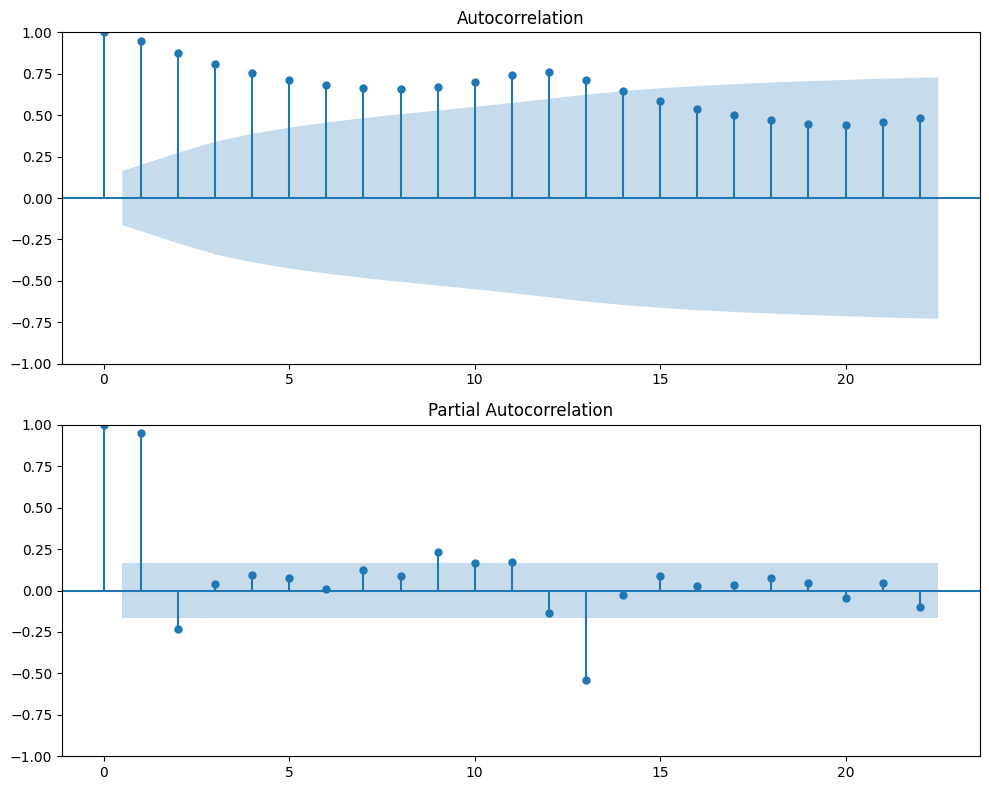

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['#Passengers'], ax=axes[0])
plot_pacf(df['#Passengers'], ax=axes[1])
plt.tight_layout()
plt.show()


The time series plot reveals strong seasonality and trend components, confirmed by the ACF and PACF plots.

The PACF, in particular, shows strong correlations for $Y(t)$$Y(t)$ with $Y(t-1)$$Y(t-1)$ and $Y(t-13)$$Y(t-13)$. This indicates that passenger volume is highly correlated with the previous month's volume and the volume from the same month in the prior year (seasonality).

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['#Passengers'])

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


To formalize our prior insight, we conducted the augmented Dickey-Fuller (ADF) test. With a null hypothesis ($H_0$) stating the series is non-stationary, the ~ 0.99 p-value led us to fail to reject $H_0$. Thus, we confirm that the series is non-stationary.

# Stationarity treatment

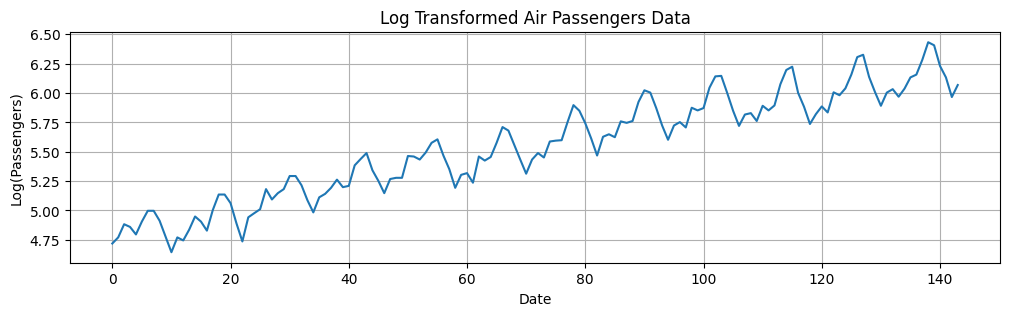

In [ ]:
df_log = np.log(df['#Passengers'])

plt.figure(figsize=(12, 3))
plt.plot(df_log)
plt.title('Log Transformed Air Passengers Data')
plt.xlabel('Date')
plt.ylabel('Log(Passengers)')
plt.grid(True)
plt.show()

As we believe the model to be multiplicative, we apply the log transformation to more easily treat the series' non-stationarity.

In a multiplicative time series model, the components (trend, seasonality, and residuals) are multiplied together. Taking the logarithm transforms this multiplicative relationship into an additive one. This is beneficial for making the variance more constant across the series and linearizing the trend and seasonality, which are assumptions often required by time series modeling techniques like differencing to achieve stationarity.

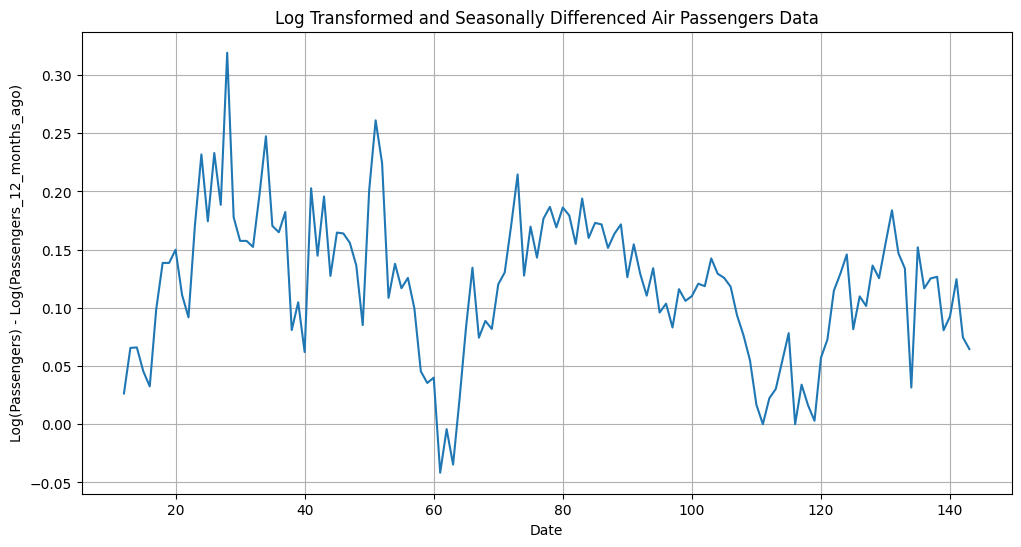

In [ ]:
df_log_seasonal_diff = df_log.diff(periods=12).dropna()

plt.figure(figsize=(12, 6))
plt.plot(df_log_seasonal_diff)
plt.title('Log Transformed and Seasonally Differenced Air Passengers Data')
plt.xlabel('Date')
plt.ylabel('Log(Passengers) - Log(Passengers_12_months_ago)')
plt.grid(True)
plt.show()

To remove the strong seasonal pattern that repeats every 12 months (for monthly data), we apply seasonal differencing. This means we subtract the value of the series from 12 months prior (e.g., subtract the January 1950 value from the January 1951 value, and so on). This helps to stabilize the mean and remove the effect of the repeating seasonal pattern.

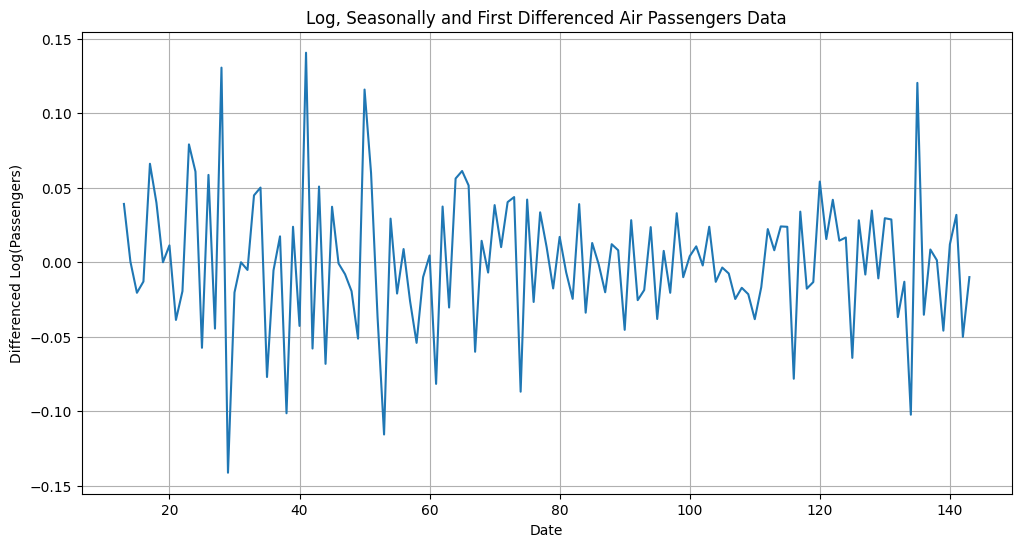

In [ ]:
df_log_seasonal_first_diff = df_log_seasonal_diff.diff(periods=1).dropna()

plt.figure(figsize=(12, 6))
plt.plot(df_log_seasonal_first_diff)
plt.title('Log, Seasonally and First Differenced Air Passengers Data')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Passengers)')
plt.grid(True)
plt.show()

After applying seasonal differencing, the series may still have a remaining trend or other forms of non-stationarity not captured by the seasonal pattern. To remove this remaining non-stationarity, we apply first-order differencing. This involves subtracting the value of the series at the previous time step from the current value (e.g., subtracting the February 1951 value from the March 1951 value, after seasonal differencing has been applied). This helps to stabilize the mean further and remove any lingering trend or other non-seasonal patterns, bringing the series closer to stationarity.

In [ ]:
print("\nADF Test on Differenced Series:")
adf_test_result = adfuller(df_log_seasonal_first_diff)
print(f'ADF Statistic: {adf_test_result[0]}')
print(f'p-value: {adf_test_result[1]}')


ADF Test on Differenced Series:
ADF Statistic: -4.4433249418311425
p-value: 0.00024859123113838495


After the prior treatments, we observe that the series becomes stationary, as confirmed by running the augmented Dickey-Fuller (ADF) test once more.

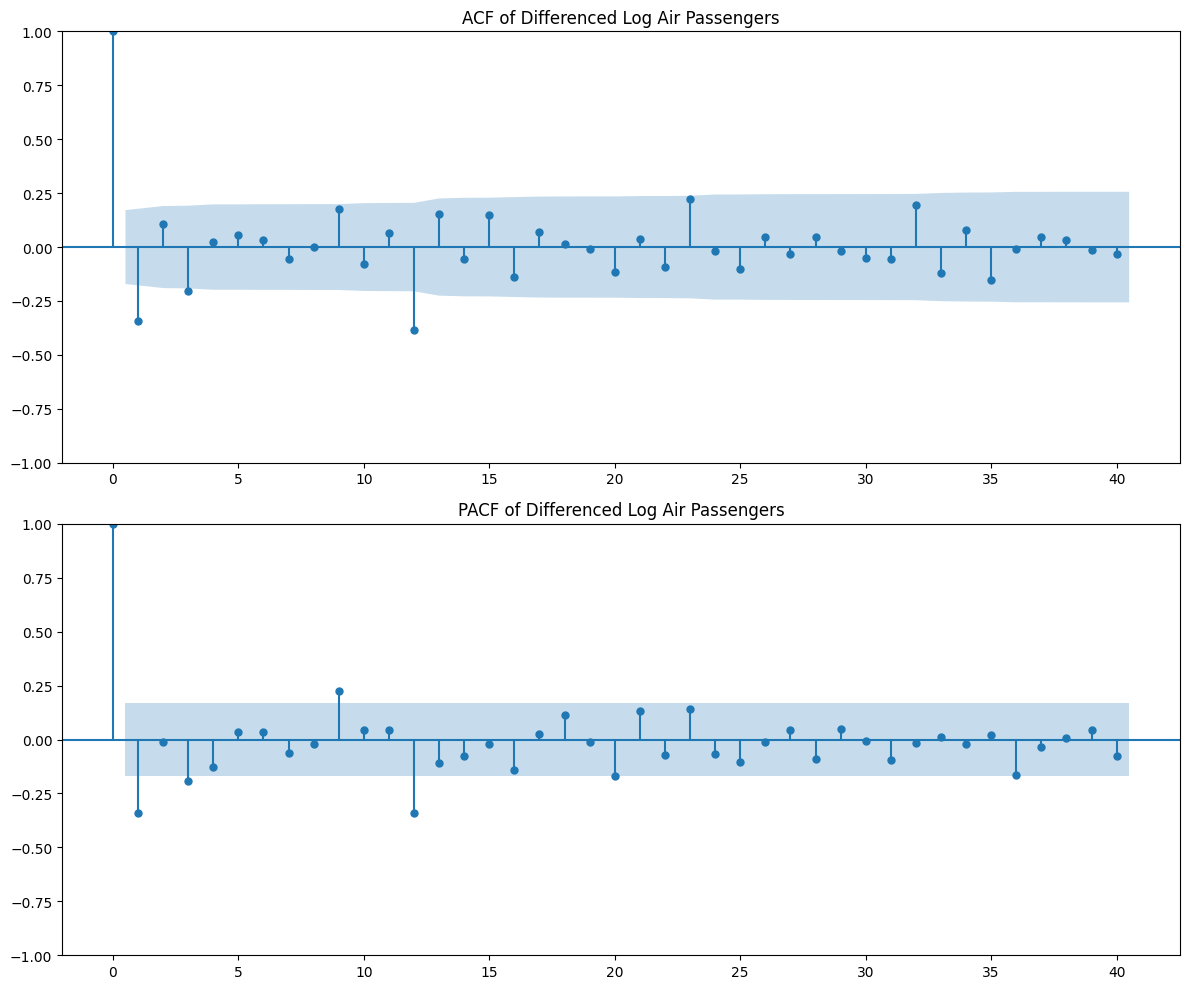

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(df_log_seasonal_first_diff, lags=40, ax=axes[0], title='ACF of Differenced Log Air Passengers')
plot_pacf(df_log_seasonal_first_diff, lags=40, ax=axes[1], title='PACF of Differenced Log Air Passengers')

plt.tight_layout()
plt.show()


Fitting SARIMA model...
                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 220.722
Date:                            Thu, 10 Jul 2025   AIC                           -435.444
Time:                                    02:38:59   BIC                           -427.157
Sample:                                         0   HQIC                          -432.079
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4328      0.075     -5.751      0.000      -0.580      -0.285
ma.S.L12  

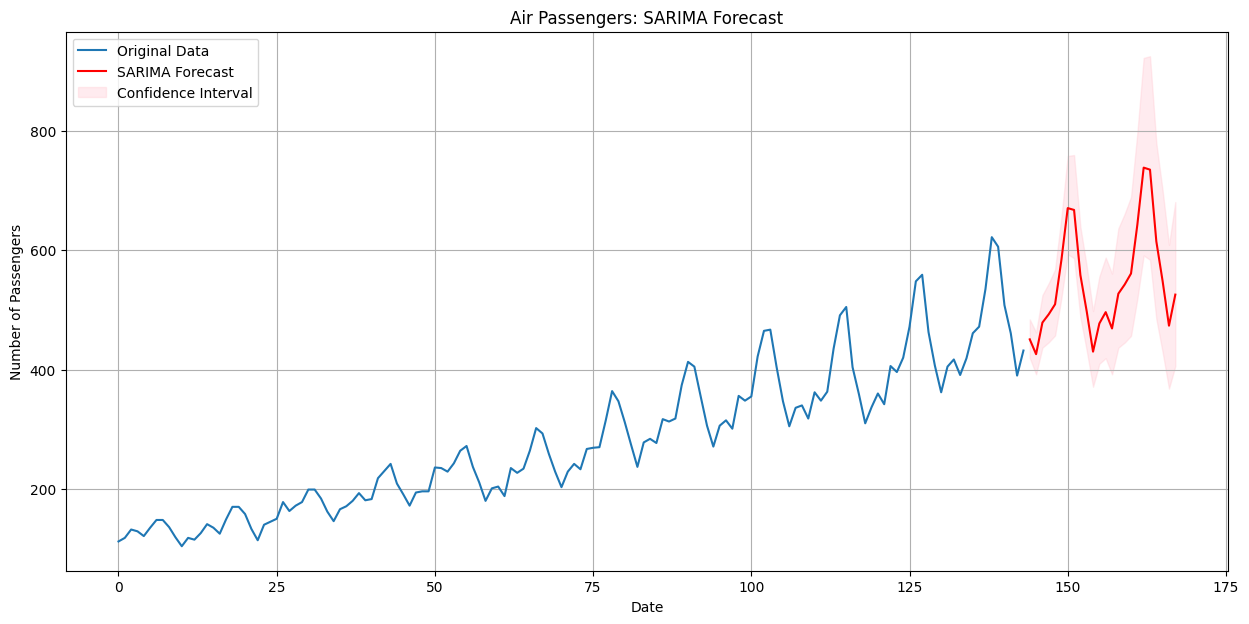

In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

order = (0, 1, 1)        # Non-seasonal (p, d, q)
seasonal_order = (0, 1, 1, 12) # Seasonal (P, D, Q, m)

# Fit the SARIMA model
print("\nFitting SARIMA model...")
model = SARIMAX(df_log, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, # Set to False if differencing is handled by (d,D)
                enforce_invertibility=False) # Set to False if you want to allow non-invertible models
# Often, setting enforce_stationarity and enforce_invertibility to False
# can help with convergence, especially with manually chosen parameters
# and when you know the series is differenced.

sarima_results = model.fit(disp=False) # disp=False suppresses optimization output
print(sarima_results.summary())

# Forecast future values
# Let's forecast for the next 24 months (2 years) beyond the historical data
forecast_steps = 24
forecast_log = sarima_results.get_forecast(steps=forecast_steps)
forecast_ci = forecast_log.conf_int()

# Transform back to original scale (exp)
forecast_original = np.exp(forecast_log.predicted_mean)
forecast_ci_original = np.exp(forecast_ci)

# Plot the original data and the forecast
plt.figure(figsize=(15, 7))
plt.plot(df['#Passengers'], label='Original Data')
plt.plot(forecast_original, label='SARIMA Forecast', color='red')
plt.fill_between(forecast_ci_original.index,
                 forecast_ci_original.iloc[:, 0],
                 forecast_ci_original.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Air Passengers: SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()